In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set_style("whitegrid")
from scipy.io import loadmat

In [5]:
#Let's get the data
data = loadmat('ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [8]:
X, y = data['X'], data['y']
print(X.shape, y.shape)
print(np.unique(y))

(5000, 400) (5000, 1)
[ 1  2  3  4  5  6  7  8  9 10]


In [83]:
#Let's create the network architecture
input_layers = X.shape[1]
hidden_layer_size = 25
num_labels = len(np.unique(y))
lam = 1

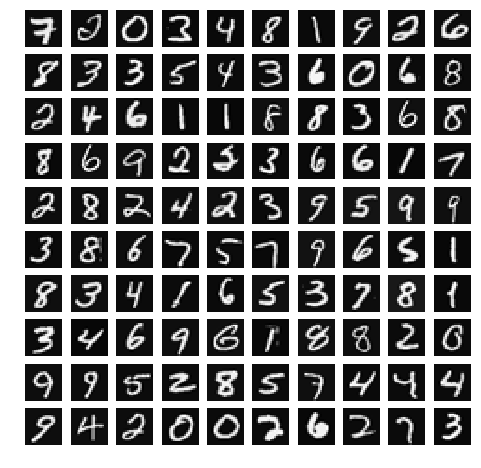

In [19]:
#Let's visualize the data
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize = (8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order = "F"), cmap = 'gray')
        axis[i,j].axis("off")


In [20]:
#Let's load the weights
nn_weights = loadmat('ex4weights.mat')

In [21]:
nn_weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [22]:
theta1, theta2 = nn_weights['Theta1'], nn_weights['Theta2']

In [23]:
print(theta1.shape, theta2.shape)

(25, 401) (10, 26)


In [31]:
X_new =    np.hstack((np.ones((5000,1)), X))
X_new.shape

(5000, 401)

In [96]:
#Let's redo the new y
y10 = np.zeros((X.shape[0], num_labels))
for i in range(1,num_labels+1):
    y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
y10.shape

(5000, 10)

In [234]:
from scipy.special import expit

def sigmoid(z):
    return expit(z)

def sigmoidgradient(z):
    return expit(z)*(1-expit(z))


def backpropagation(theta1, theta2, X,y,num_labels,lam):
    #get the activation of the hidden layer
    m,n = X.shape[0], X.shape[1]
    J = 0 
    X_new  = np.hstack((np.ones((m,1)), X))
    a2 = sigmoid(np.dot(X_new,theta1.T))
    a2 = np.hstack((np.ones((m,1)), a2)) #add +1 column for bias 
    a3 = sigmoid(np.dot(a2, theta2.T))
    
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a3[:,j]) - (1-y10[:,j])*np.log(1-a3[:,j])) #compute the cost for each label column
        
    cost = (1/m)* J
    reg_J = cost + lam/(2*m)* (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))) #square theta but not for bias column
    
    grad1 = np.zeros((theta1.shape))
    grad2 = np.zeros((theta2.shape))

    #return np.argmax(a3,axis=1)+1
    #return cost
    #implement backprop
    for i in range(m): #let's go one by one for m training samples
        xi = X_new[i,:] #ith row for ith training sample
        a2i = a2[i,:]
        a3i = a3[i,:]
        d3 = a3i - y10[i,:]
        d2 = np.dot(theta2.T, d3)* sigmoidgradient(np.hstack((1,np.dot(xi,theta1.T))))
        
        grad1 = grad1 + np.dot(d2[1:][:,np.newaxis],xi[:,np.newaxis].T)
        grad2 = grad2 + np.dot(d3[:,np.newaxis],a2i[:,np.newaxis].T)
    
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (lam/m)*(np.hstack((np.zeros((theta1.shape[0],1)),theta1[:,1:])))
    grad2_reg = grad2 + (lam/m)*(np.hstack((np.zeros((theta2.shape[0],1)),theta2[:,1:])))
    
    return cost, grad1, grad2, reg_J,grad1_reg,grad2_reg


In [235]:
cost_ret, grad1_ret, grad2_ret,reg_J, grad1_reg,grad2_reg = backpropagation(theta1,theta2,X,y,10,1)

In [236]:
print("Cost at parameters (non-regularized):",cost_ret,"\nCost at parameters (Regularized):",reg_J)

Cost at parameters (non-regularized): 0.2876291651613188 
Cost at parameters (Regularized): 0.38376985909092354


In [237]:
def initializeweight(L_in, L_out):
    '''randomly initialize weights for a layer with L_in incoming connections and L_out outgoing connections'''
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in+1)*(2*epi)-(epi)
    return W

In [238]:
initial_Theta1 = initializeweight(input_layers, hidden_layer_size)
initial_Theta2 = initializeweight(hidden_layer_size, num_labels)

In [239]:
initial_Theta1.shape
initial_Theta2.shape

(10, 26)

In [244]:
#Implement gradient descent to update theta parameters

def gradientdescent(X,y,initial_Theta1,initial_Theta2,alpha,num_iters,lam,input_layers,hidden_layer_size,num_labels):
    #for a given number of iterations, get gradients and update theta parameters
    J_history= []
    theta1 = initial_Theta1
    theta2 = initial_Theta2
    for i in range(num_iters):
        cost, grad1, grad2 = backpropagation(theta1,theta2,X,y,num_labels,lam)[3:]
        theta1 = theta1 - (alpha*grad1)
        theta2 = theta2 - (alpha*grad2)
        J_history.append(cost)
    
    #nn_paramsFinal = np.append(theta1.flatten(),theta2.flatten())
    return theta1, theta2, J_history

In [245]:
theta1_final, theta2_final, J_history = gradientdescent(X,y,initial_Theta1, initial_Theta2,0.8,800,1, input_layers, hidden_layer_size,num_labels)

In [246]:
def predict_nn(Theta1, Theta2,X):
    m = X.shape[0] #number of rows
    X_new = np.hstack((np.ones((m,1)),X))
    a1 = sigmoid(np.dot(X_new,Theta1.T))
    a1 = np.hstack((np.ones((m,1)),a1))
    a2 = sigmoid(np.dot(a1,Theta2.T)) #output layer
    
    return np.argmax(a2, axis = 1)+1

pred3 = predict_nn(theta1_final, theta2_final, X)
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 94.16 %
